In [ ]:
import requests
import gensim.downloader as api
import numpy as np

import re

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, auc, precision_recall_curve

In [ ]:
data_train = requests.get('https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu')
data_test = requests.get('https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-test.conllu')
data_dev = requests.get('https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-dev.conllu')

START = '*START*'
END = '*END*'

In [ ]:
def tokenizer(data):

  raw_text = data.text.strip()
  raw_docs = re.split(r'\n\t?\n', raw_text)
  token_docs = []
  tag_docs = []
  sentences = []

  for doc in raw_docs:
    tokens = [START]
    tags = []
    for line in doc.split('\n'):
      if (len(line.split('\t')) != 1):
        tokens.append(line.split('\t')[1].lower())
        tags.append(line.split('\t')[3])

    tokens.append(END)
    token_docs.append(tokens)
    tag_docs.append(tags)

  return  token_docs, tag_docs

#### Validity for pos tagging and tokens. Should have the same size (with substract 2 cause of the pseudotoken start & end)

In [ ]:
token_docs_train, tag_docs_train = tokenizer(data_train)
token_docs_test, tag_docs_test = tokenizer(data_test)
token_docs_dev, tag_docs_dev = tokenizer(data_dev)

#validity for pos tagging and tokens.
for i in range(len(token_docs_train)):
  if len(token_docs_train[i]) - len(tag_docs_train[i]) != 2:
    print(i)

#### Size of training, development and test datasets

In [ ]:
print('Training sentences :', len(token_docs_train))
print('Test sentences :', len(token_docs_test))
print('Development sentences :', len(token_docs_dev))

Training sentences : 8548
Test sentences : 1096
Development sentences : 1117


### Get Number of labels and check support for each label

##### '_' ---> word contains apostrophe while 'X' ---> not english

In [ ]:
flatten_tags_dev = [t for tag in tag_docs_dev for t in tag]
flatten_tags_test = [t for tag in tag_docs_test for t in tag]
flatten_tags_train = [t for tag in tag_docs_train for t in tag]

print('Training set labels :', sorted(set(flatten_tags_train)))
print('Test set labels :', sorted(set(flatten_tags_test)))
print('Development set labels :', sorted(set(flatten_tags_dev)))

N_CLASSES = len(set(flatten_tags_train))
print('\nNumber of labels :', N_CLASSES)
print('Vocabulary size :', len(set(t for token in token_docs_train for t in token)) - 2)


def average_sentence_length(sentences):
  sent_sizes = []

  for sent in sentences:
    sent_sizes.append(len(sent) - 2)

  return int(np.mean(np.array(sent_sizes)))

print('\nAverage sentence length of training set :', average_sentence_length(token_docs_train))
print('Average sentence length of development set :', average_sentence_length(token_docs_dev))
print('Average sentence length of test set :', average_sentence_length(token_docs_test))

Training set labels : ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']
Test set labels : ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']
Developement set labels : ['ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', '_']

Number of labels : 18
Vocabulary size : 14826

Average sentence length of training set : 17
Average sentence length of developement set : 17
Average sentence length of test set : 18


### Create d-Window mini-sentences

In [ ]:
# from more_itertools import windowed

def window_tokenized(WINDOW_NUMBER, token_docs):
  windowed_token_docs = []
  for sent in token_docs:
    temp = [[sent[idx + i] for i in range(WINDOW_NUMBER)] for idx in range(len(sent) - WINDOW_NUMBER + 1)]
    windowed_token_docs.append(temp)

  return [window for m_sentence in windowed_token_docs for window in m_sentence]

In [ ]:
window = 3

windowed_token_docs_train = window_tokenized(window, token_docs_train)
windowed_token_docs_test = window_tokenized(window, token_docs_test)
windowed_token_docs_dev = window_tokenized(window, token_docs_dev)


print('Training mini-sentences :', len(windowed_token_docs_train), 'and Training y_true :', len(flatten_tags_train))
print('Test mini-sentences :', len(windowed_token_docs_test), 'and Test y_true :', len(flatten_tags_test))
print('Development mini-sentences :', len(windowed_token_docs_dev), 'and Development y_true :', len(flatten_tags_dev))

Training mini-sentences : 150374 and Training y_true : 150374
Test mini-sentences : 20195 and Test y_true : 20195
Development mini-sentences : 19997 and Developement y_true : 19997


### Create 1-hot vectors for y_true label

In [ ]:
mlb = MultiLabelBinarizer()

y_train_1_hot  = mlb.fit_transform([[tag] for tag in flatten_tags_train])
y_test_1_hot  = mlb.transform([[tag] for tag in flatten_tags_test])
y_dev_1_hot  = mlb.transform([[tag] for tag in flatten_tags_dev])

### Get features for each mini-sentence using pre-trained word embeddings

In [ ]:
api.info()['models'].keys()

embeddings = api.load('glove-wiki-gigaword-100')

embeddings[START] = np.zeros(100)
embeddings[END] = np.zeros(100)

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
def create_features(mini_sentences, attention):

  attention_embeddings = []

  for mini_sent in mini_sentences:
    mini_sent_embeddings = []

    for token in mini_sent:

      try:
        mini_sent_embeddings.append(embeddings[token])
      except KeyError:
        mini_sent_embeddings.append(np.zeros(100))

    attention_embeddings.append(attention.dot(np.array(mini_sent_embeddings)))

  return np.array(attention_embeddings)


attention_list = np.array([0.2, 0.6, 0.2])

x_train = create_features(windowed_token_docs_train, attention_list)
x_test = create_features(windowed_token_docs_test, attention_list)
x_dev = create_features(windowed_token_docs_dev, attention_list)

print('Training set shape :', x_train.shape)
print('Test set shape :', x_test.shape)
print('Development set shape :', x_dev.shape)

Training set shape : (150374, 100)
Test set shape : (20195, 100)
Developement set shape : (19997, 100)


In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

def model_builder(hp):

  hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
  hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
  hp_dropout = hp.Float('rate', min_value=0.1, max_value=0.5, step=0.2)
  hp_learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.1, step=10, sampling='log')


  model = Sequential()
  model.add(Dense(units=hp_units, input_dim=x_train.shape[1], activation='relu'))
  model.add(Dropout(rate = hp_dropout))
  model.add(Dense(units=hp_units_2,  activation='relu'))
  model.add(Dropout(rate = hp_dropout))
  model.add(Dense(N_CLASSES,  activation='softmax'))

  model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(
  from_logits=False),
  optimizer=Adam(learning_rate=hp_learning_rate),
  metrics=['accuracy']
  )

  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


tuner.search(x_train, y_train_1_hot, epochs=50, validation_data=(x_dev, y_dev_1_hot), callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, in the second densely-connected layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')},the dropout probability is: {best_hps.get('rate')}.
""")

Trial 30 Complete [00h 03m 54s]
val_accuracy: 0.1690753549337387

Best val_accuracy So Far: 0.9277891516685486
Total elapsed time: 01h 13m 40s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 256, in the second densely-connected layer is 256 and the optimal learning rate for the optimizer
is 0.0001,the dropout probability is: 0.1.



In [ ]:
model = tuner.hypermodel.build(best_hps)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               25856     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 18)                4626      
                                                                 
Total params: 96274 (376.07 KB)
Trainable params: 96274 (376.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
import time

with tf.device('/device:GPU:0'):

  start_training_time = time.time()

  history = model.fit(
      x_train,
      y_train_1_hot,
      validation_data=(x_dev, y_dev_1_hot),
      batch_size=32,
      epochs=50,
      shuffle=True
      )

  end_training_time = time.time()

  print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
4700/4700 [==============================] - 19s 4ms/step - loss: 1.0177 - accuracy: 0.6834 - val_loss: 0.6234 - val_accuracy: 0.8036
Epoch 2/50
4700/4700 [==============================] - 18s 4ms/step - loss: 0.6126 - accuracy: 0.8051 - val_loss: 0.4834 - val_accuracy: 0.8493
Epoch 3/50
4700/4700 [==============================] - 20s 4ms/step - loss: 0.5030 - accuracy: 0.8405 - val_loss: 0.4086 - val_accuracy: 0.8743
Epoch 4/50
4700/4700 [==============================] - 18s 4ms/step - loss: 0.4394 - accuracy: 0.8599 - val_loss: 0.3617 - val_accuracy: 0.8887
Epoch 5/50
4700/4700 [==============================] - 19s 4ms/step - loss: 0.3991 - accuracy: 0.8726 - val_loss: 0.3321 - val_accuracy: 0.8967
Epoch 6/50
4700/4700 [==============================] - 19s 4ms/step - loss: 0.3693 - accuracy: 0.8817 - val_loss: 0.3075 - val_accuracy: 0.9022
Epoch 7/50
4700/4700 [==============================] - 18s 4ms/step - loss: 0.3455 - accuracy: 0.8885 - val_loss: 0.2957 - val_ac

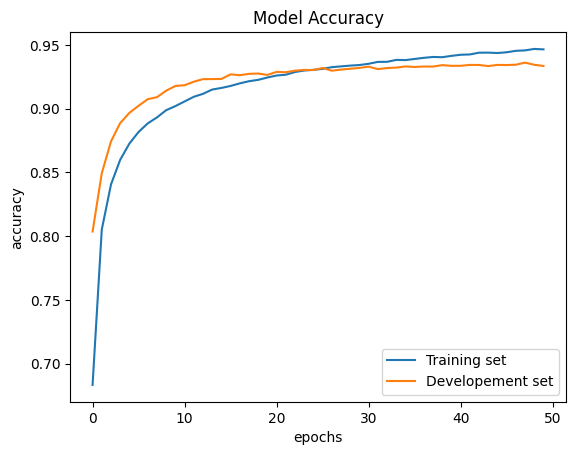

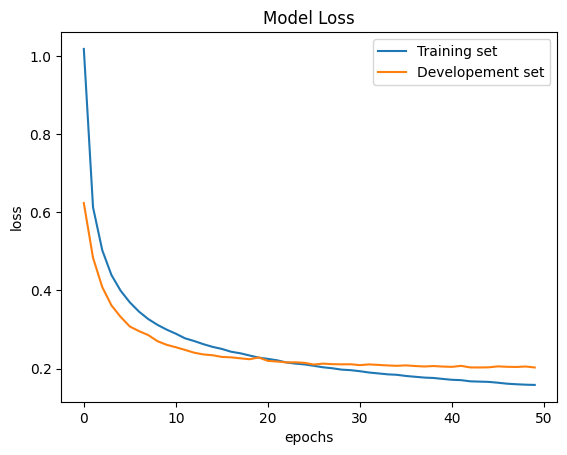

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='upper right')
plt.show()

# Metrics

Precision , Recall , F1 , AUC scores for each classifier

In [ ]:
def prec_rec_auc(y_true, y_pred, N_CLASSES):
  precision = dict()
  recall = dict()
  auc_score = dict()

  for i in range(N_CLASSES):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc_score[mlb.classes_[i]] = auc(recall[i], precision[i])

  return precision, recall, auc_score


def macro_auc(auc_scores):
  auc = []

  for key in auc_scores.keys():
    auc.append(auc_scores[key])

  return np.mean(np.array(auc))


dummy = OneVsRestClassifier(DummyClassifier(strategy="stratified"))
dummy.fit(x_train , y_train_1_hot)

model = tuner.hypermodel.build(best_hps)
model.fit(x_train, y_train_1_hot, validation_data=(x_dev, y_dev_1_hot), batch_size=32, epochs=best_epoch, shuffle=True)


dummy_predictions_train = dummy.predict(x_train)
dummy_predictions_train_proba = dummy.predict_proba(x_train)
_ , _, dummy_auc_train = prec_rec_auc(y_train_1_hot, dummy_predictions_train_proba, N_CLASSES)

dummy_predictions_dev = dummy.predict(x_dev)
dummy_predictions_dev_proba = dummy.predict_proba(x_dev)
_ , _, dummy_auc_dev = prec_rec_auc(y_dev_1_hot, dummy_predictions_dev_proba, N_CLASSES)

dummy_predictions_test = dummy.predict(x_test)
dummy_predictions_test_proba = dummy.predict_proba(x_test)
_ , _, dummy_auc_test = prec_rec_auc(y_test_1_hot, dummy_predictions_test_proba, N_CLASSES)


mlp_predictions_train = model.predict(x_train)
_, _, mlp_auc_train = prec_rec_auc(y_train_1_hot, mlp_predictions_train, N_CLASSES)

mlp_predictions_dev = model.predict(x_dev)
_, _, mlp_auc_dev = prec_rec_auc(y_dev_1_hot, mlp_predictions_dev, N_CLASSES)

mlp_predictions_test = model.predict(x_test)
_, _, mlp_auc_test = prec_rec_auc(y_test_1_hot, mlp_predictions_test, N_CLASSES)



print('\n--------- Baseline Dummy Classifier ---------\n')
print('Training set\n')
print(classification_report(y_train_1_hot, dummy_predictions_train, target_names = mlb.classes_, zero_division=0.0))
print('AUC training :', dummy_auc_train, '\n')
print('Macro AUC :', macro_auc(dummy_auc_train), '\n')
print('\nDevelopment set\n')
print(classification_report(y_dev_1_hot, dummy_predictions_dev, target_names = mlb.classes_, zero_division=0.0))
print('AUC development :', dummy_auc_dev, '\n')
print('Macro AUC :', macro_auc(dummy_auc_dev), '\n')
print('\nTest set\n')
print(classification_report(y_test_1_hot, dummy_predictions_test, target_names = mlb.classes_, zero_division=0.0))
print('AUC test :', dummy_auc_test, '\n')
print('Macro AUC :', macro_auc(dummy_auc_test), '\n')


print('\n--------- Custom MLP ---------\n')
print('Training set\n')
print(classification_report(y_train_1_hot, np.round(mlp_predictions_train), target_names = mlb.classes_, zero_division=0.0))
print('AUC training :', mlp_auc_train, '\n')
print('Macro AUC :', macro_auc(mlp_auc_train), '\n')
print('\nDevelopment set\n')
print(classification_report(y_dev_1_hot, np.round(mlp_predictions_dev), target_names = mlb.classes_, zero_division=0.0))
print('AUC development :', mlp_auc_dev, '\n')
print('Macro AUC :', macro_auc(mlp_auc_dev), '\n')
print('\nTest set\n')
print(classification_report(y_test_1_hot, np.round(mlp_predictions_test), target_names = mlb.classes_, zero_division=0.0))
print('AUC test :', mlp_auc_test, '\n')
print('Macro AUC :', macro_auc(mlp_auc_test), '\n')

Epoch 1/48
4700/4700 [==============================] - 20s 4ms/step - loss: 1.0075 - accuracy: 0.6904 - val_loss: 0.6111 - val_accuracy: 0.8093
Epoch 2/48
4700/4700 [==============================] - 18s 4ms/step - loss: 0.5999 - accuracy: 0.8112 - val_loss: 0.4684 - val_accuracy: 0.8596
Epoch 3/48
4700/4700 [==============================] - 19s 4ms/step - loss: 0.4920 - accuracy: 0.8451 - val_loss: 0.3977 - val_accuracy: 0.8770
Epoch 4/48
4700/4700 [==============================] - 19s 4ms/step - loss: 0.4330 - accuracy: 0.8623 - val_loss: 0.3537 - val_accuracy: 0.8902
Epoch 5/48
4700/4700 [==============================] - 19s 4ms/step - loss: 0.3934 - accuracy: 0.8741 - val_loss: 0.3307 - val_accuracy: 0.8956
Epoch 6/48
4700/4700 [==============================] - 19s 4ms/step - loss: 0.3631 - accuracy: 0.8837 - val_loss: 0.3072 - val_accuracy: 0.9031
Epoch 7/48
4700/4700 [==============================] - 19s 4ms/step - loss: 0.3419 - accuracy: 0.8896 - val_loss: 0.2915 - val_ac